<a href="https://colab.research.google.com/github/GLopezMUZH/Packing_and_Vehcicle_Routing/blob/main/L%26GV_Ex4_Part2_CW_wh_and_routes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ETHZ - IVT - Logistik und Güterverkehr SS2021
# Assignment 4: Operating a logistics system - Part2 - Vehicle Routing and Facility Location

* Gabriela López Magaña
* Alexander Hoz
* Jackson Buckner
01.06.2021

In [1]:
from scipy.io import loadmat
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from operator import itemgetter
from copy import deepcopy
import sys

In [2]:
sys.setrecursionlimit(15000) # > len(savings)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data and visualisation functions

In [4]:
def plot_clients(G, pos_dict, fig_size=15):
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    plt.title('Client locations')
    nx.draw(G, pos=pos_dict, with_labels = True, node_color='lightblue',node_size=500,edgelist=[],ax=ax)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.grid(True, which='both')

    plt.show()

In [5]:
def get_graph_data(clients_array):

    columns = ['client_id','client_x', 'client_y','client_demand']
    clients_df = pd.DataFrame(clients_array, columns=columns)
    client_coordinates = clients_df[['client_x','client_y']].values.tolist()

    client_names = np.arange(0, len(client_coordinates), 1)
    G = nx.Graph() 
    G.add_nodes_from(client_names)

    # %%
    i=0
    pos_dict = {}
    for c_l in client_coordinates:
        #print(c_l)
        pos_dict[i] = c_l
        for j in range(1, G.number_of_nodes()):
            if not (i == j):
                dist = np.sqrt( (c_l[0] - client_coordinates[j][0])**2 + (c_l[1] - client_coordinates[j][1])**2 )
                #print(str(i) + " -> " + str(j) + ":" + str(dist)) # prints the distance between the two nodes
                G.add_edge(i,j,weight=dist, length=dist)
        i += 1
    return G, pos_dict


# WH Location functions

In [6]:
def get_location_in_geometric_mean(client_coordinates_list):
    columns = ['client_x', 'client_y']
    clients_df = pd.DataFrame(client_coordinates_list, columns=columns)
    # get geometric mean
    wh_location = (sum(clients_df.client_x) / len(clients_df), sum(clients_df.client_y) / len(clients_df))
    print(wh_location)
    #print(round(wh_location[0],2), ', ', round(wh_location[1],2))
    return wh_location

# Clarke-Wright functions

In [7]:
# clients_array = [id, x, y, demand]
def set_CW_data(clients_array, capacity, correction_factor_euclidean_distance=1):
    global routes, savings, node_to_route, vehicleCapacity, customers

    customer_count = len(clients_array)
    #k_ = 5 #int(numbers[1])
    #vehicleCount = 5 #int(numbers[1])
    assigned = [-1] * customer_count
    vehicleCapacity = capacity
    print('customer_count: ', customer_count)
    print('vehicleCapacity: ', vehicleCapacity)


    customers = clients_array # client_id, x_cood, y_coord, demand
    routes = []
    node_to_route = []
    savings = []


    # initialize one route per customer
    for i in range(0, customer_count):
        routes.append([0, i, 0])

    # initialize node to route map
    node_to_route = [[0, i, 0] for i in range(0, customer_count)]

    # initiaize customer_count x customer_count distances array
    distances = [[0 for x in range(customer_count)] for y in range(customer_count)]

    # calculate distances
    for i in range(0, customer_count):
        for j in range(0, customer_count):
                distances[i][j] = math.sqrt((customers[i][1] - customers[j][1])**2 + (customers[i][2] - customers[j][2])**2) * correction_factor_euclidean_distance
    

    # calculate savings
    for i in range(1, customer_count):
        for j in range(i + 1, customer_count):
            if not i == j:
                sv = distances[0][i] + distances[0][j] - distances[i][j]
            else:
                sv = 0
            savings.append([[i, j], sv])

    # sort saving descending order
    savings = sorted(savings, key=itemgetter(1), reverse=True)

    return distances, savings

In [8]:
# Code based on https://github.com/Yilkici/Clarke_Wright_Algorithm_Python/blob/master/clarke_wright.py
def combine_routes(n1, n2, r1, r2, opt):
    newR = []

    if r1 == r2:
        #print("routes are equal")
        return r1

    # both nodes are not in modified route
    if opt == 0:
        newR = [0, n1, n2, 0]
    # one node exists in modified route
    elif opt == 1:
        # is end node of route
        if r2[-2] == n2:
            newR = newR + r2[0:-1]
            newR = newR + [n1, 0]
        # is begining of route
        if r2[1] == n2:
            newR = newR + [0, n1]
            newR = newR + r2[1:]
    # both nodes exist in modified route
    else:
        # both are start nodes
        if r1[1] == n1 and r2[1] == n2:
            rev_r1 = r1[::-1]
            newR = newR + rev_r1[:-1]
            newR = newR + r2[1:]
        # n1 is start node, n2 is end node
        elif r1[1] == n1 and r2[-2] == n2:
            newR = newR + r2[0:-1]
            newR = newR + r1[1:]
        # n1 ist end node, n2 ist start node
        elif r1[-2] == n1 and r2[1] == n2:
            newR = newR + r1[0:-1]
            newR = newR + r2[1:]
        else:
            # both are end nodes
            rev_r2 = r2[::-1]
            newR = newR + r1[0:-1]
            newR = newR + rev_r2[1:]

    return  newR

def compute_tot_demand(r):
    demands = [customers[i][3] for i in r[1:-1]]
    return  sum(demands)

def is_external(n, r):
    if r[-2] == n or r[1] == n:
        return True
    return False

def print_CW_routes_for_customers():
    for i in range(0, len(customers)):
        print("route for customer ", i, " ", node_to_route[i])

In [9]:
def get_CW_graph(do_print=False):
    n_t_r = sorted(node_to_route)
    uniqueList = []
    color_table = ['blue', 'yellow', 'lavender', 'lightblue', 'darkblue', 'magenta', 'orange', 'yellowgreen','indigo']
    customer_count = len(customers)
    total_distance = 0

    for route in n_t_r:
        if route not in uniqueList:
            uniqueList.append(route)

    if do_print:
        print("number of routes: ", len(uniqueList))
    
    color_map = [0]*customer_count
    client_names = np.arange(0, customer_count-1, 1)
    G2 = nx.Graph() 
    G2.add_nodes_from(client_names)

    prev_node = 0
    idx_color = -1
    for route in uniqueList: 
        route_lengt = 0
        idx_color += 1
        for node in route:
            """
            print('prev_node: ', prev_node)
            print('node: ', node)
            print('dist: ', distances[prev_node][node])
            """
            color_map[node] = color_table[idx_color]
            dist = distances[prev_node][node]
            route_lengt += dist
            if prev_node != node:
                #print("add edge i, j:", prev_node, node)
                G2.add_edge(prev_node,node,weight=dist, length=dist)
            prev_node = node
        if do_print:
            print("length: ", route_lengt, ", steps: ", len(route), ", route: ", route)
        total_distance += route_lengt

    print("total distance: ", total_distance)

    return G2, color_map, uniqueList

In [10]:
def draw_graph_paths(G2, clients_array, color_map, fig_size=15):
    columns = ['client_id','client_x', 'client_y','client_demand']
    clients_df = pd.DataFrame(clients_array, columns=columns)
    client_coordinates = clients_df[['client_x','client_y']].values.tolist()

    pos_dict2 = { i : clients_df[['client_x','client_y']].values.tolist()[i] for i in range(0, len(clients_df) ) }

    #print(color_map)

    e_labels = {e: round(G2.edges[e]['weight'],ndigits=1) for e in G2.edges}

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    #plt.title('Client locations')
    nx.draw(G2, pos=pos_dict2, with_labels = True, node_color=color_map,node_size=1000,ax=ax)
    nx.draw_networkx_edge_labels(G, pos=pos_dict2, edge_labels=e_labels)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.grid(True, which='both')
    plt.show()

In [11]:
# 3 - CW loop over savings 
# Code based on https://github.com/Yilkici/Clarke_Wright_Algorithm_Python/blob/master/clarke_wright.py
def CW():

    if len(savings) == 0:
        #print("Error Savings is empty")
        return

    chosen = savings[0]
    savings.remove(chosen)
    n1 = chosen[0][0]
    n2 = chosen[0][1]

    r1 = node_to_route[n1]
    r2 = node_to_route[n2]

    #breakpoint()

    #if (int(n1) == 23):
    #print("n1: ", n1, ", n2: ", n2)
    #print("r1: ", r1)
    #print("r2: ", r2)


    # first attempt on both routes
    if len(r1) == 3 and len(r2) == 3:
        new_r = combine_routes(n1, n2, r1, r2, 0)
        if compute_tot_demand(new_r) <= vehicleCapacity:
            for i in range(0, len(new_r)):
                node = new_r[i]
                node_to_route[node] = new_r
    # r2 was already modified
    if len(r1) == 3 and len(r2) > 3:
        if is_external(n2, r2):
            new_r = combine_routes(n1, n2, r1, r2, 1)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r
    # r1 was already modified
    if len(r1) > 3 and len(r2) == 3:
        if is_external(n1, r1):
            new_r = combine_routes(n2, n1, r2, r1, 1)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r
    # both routes have been modified
    if len(r1) > 3 and len(r2) > 3:
        if is_external(n1, r1) and is_external(n2, r2):
            new_r = combine_routes(n1, n2, r1, r2, 2)
            if compute_tot_demand(new_r) <= vehicleCapacity:
                for i in range(0, len(new_r)):
                    node = new_r[i]
                    node_to_route[node] = new_r

    CW()

# Excercise **4** data

In [12]:
file1_dir_path = '/content/gdrive/MyDrive/UZH_varios/ETH_L&GV_Ex4/inputDataAssignment.mat'
file1_dict = loadmat(file1_dir_path)

In [13]:
M_val = file1_dict.get("M")[0][0]
C_list = [[element for element in upperElement] for upperElement in file1_dict['C']]
nr_clients = len(C_list)
print("Truck capacity: ",M_val)
print("Number of clients: ", len(C_list))

Truck capacity:  35
Number of clients:  155


## Get Warehouse Location, use gemoetric mean

In [14]:
wh_location = get_location_in_geometric_mean(C_list)

(37.6912454268771, 38.92380135992632)


## Vehicle Routing

In [15]:
# convert list to array
C_arr = np.asarray(C_list)

# set demands of each client to 1
dem = [1]*nr_clients
# set the id of the clients in the array
clt_ids = np.arange(1,nr_clients+1,1)
# transform to numpy arrays
id_nr_arr = np.array(clt_ids, dtype= int)
dem_arr = np.array(dem, dtype = int)

# create numpy array with structure [id, xcoord, ycoord, demand]
clt_arr = np.hstack((id_nr_arr[:, None], C_arr, dem_arr[:, None]))

# set warehouse values
warehouse = [] #[client_id=0, 30.0, 40.0, demand=0]
warehouse = [0,round(wh_location[0],2), round(wh_location[1],2), 0]
customers = []

In [17]:
# add Warehouse as the first row i array (index = 0)
clt_arr_n = np.vstack((warehouse,clt_arr))
clt_arr = []
clt_arr = clt_arr_n

print(len(clt_arr))
print(clt_arr[:3])
print("...")
print(clt_arr[-3:])

157
[[ 0.         37.69       38.92        0.        ]
 [ 0.         37.69       38.92        0.        ]
 [ 1.         11.88696591 21.95590303  1.        ]]
...
[[153.          21.50635991  47.83117871   1.        ]
 [154.          26.73056863  59.27967205   1.        ]
 [155.           0.81861671  57.04687754   1.        ]]


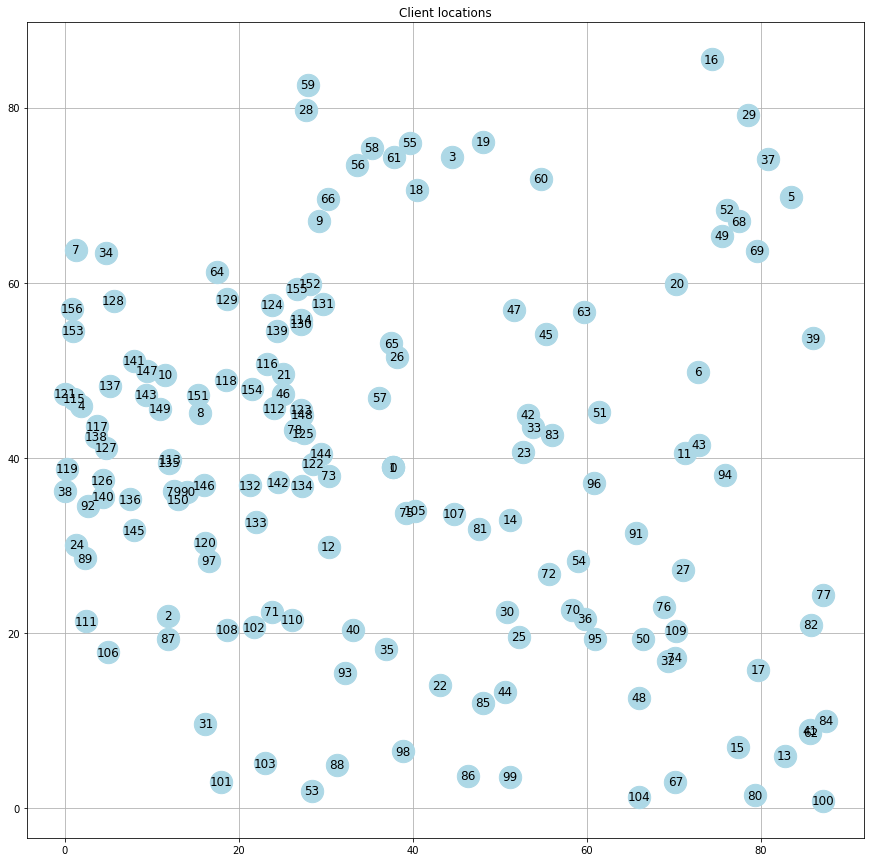

In [18]:
G, pos_dict = get_graph_data(clt_arr_n)
plot_clients(G, pos_dict,15)

### Apply CW to Ex 4

In [19]:
distances, savings = set_CW_data(clt_arr, M_val)

customer_count:  157
vehicleCapacity:  35


In [20]:
CW()

In [ ]:
#print_CW_routes_for_customers()

In [21]:
G2, color_map, unique_routes = get_CW_graph(True)

number of routes:  5
length:  197.0579689609678 , steps:  37 , route:  [0, 40, 93, 35, 22, 44, 85, 99, 86, 98, 88, 53, 103, 101, 31, 108, 102, 71, 110, 135, 113, 149, 143, 147, 10, 151, 8, 118, 154, 116, 21, 46, 112, 123, 148, 78, 0]
length:  234.46755519515273 , steps:  38 , route:  [0, 42, 33, 83, 51, 96, 72, 54, 91, 11, 43, 94, 27, 76, 109, 32, 74, 17, 77, 82, 84, 41, 62, 100, 13, 80, 15, 67, 104, 48, 50, 95, 36, 70, 25, 30, 1, 0]
length:  269.3642209468609 , steps:  37 , route:  [0, 47, 45, 63, 20, 6, 39, 69, 49, 52, 68, 5, 37, 29, 16, 60, 19, 3, 61, 55, 58, 59, 28, 56, 66, 9, 18, 131, 152, 155, 124, 64, 129, 139, 114, 130, 0]
length:  91.72976389795093 , steps:  17 , route:  [0, 73, 144, 125, 122, 134, 12, 75, 105, 107, 81, 14, 23, 26, 65, 57, 0]
length:  166.78630749926526 , steps:  37 , route:  [0, 133, 120, 97, 2, 87, 106, 111, 89, 24, 92, 38, 119, 138, 117, 4, 115, 121, 153, 156, 7, 34, 128, 141, 137, 127, 126, 140, 136, 145, 79, 150, 90, 146, 132, 142, 0]
total distance:  959

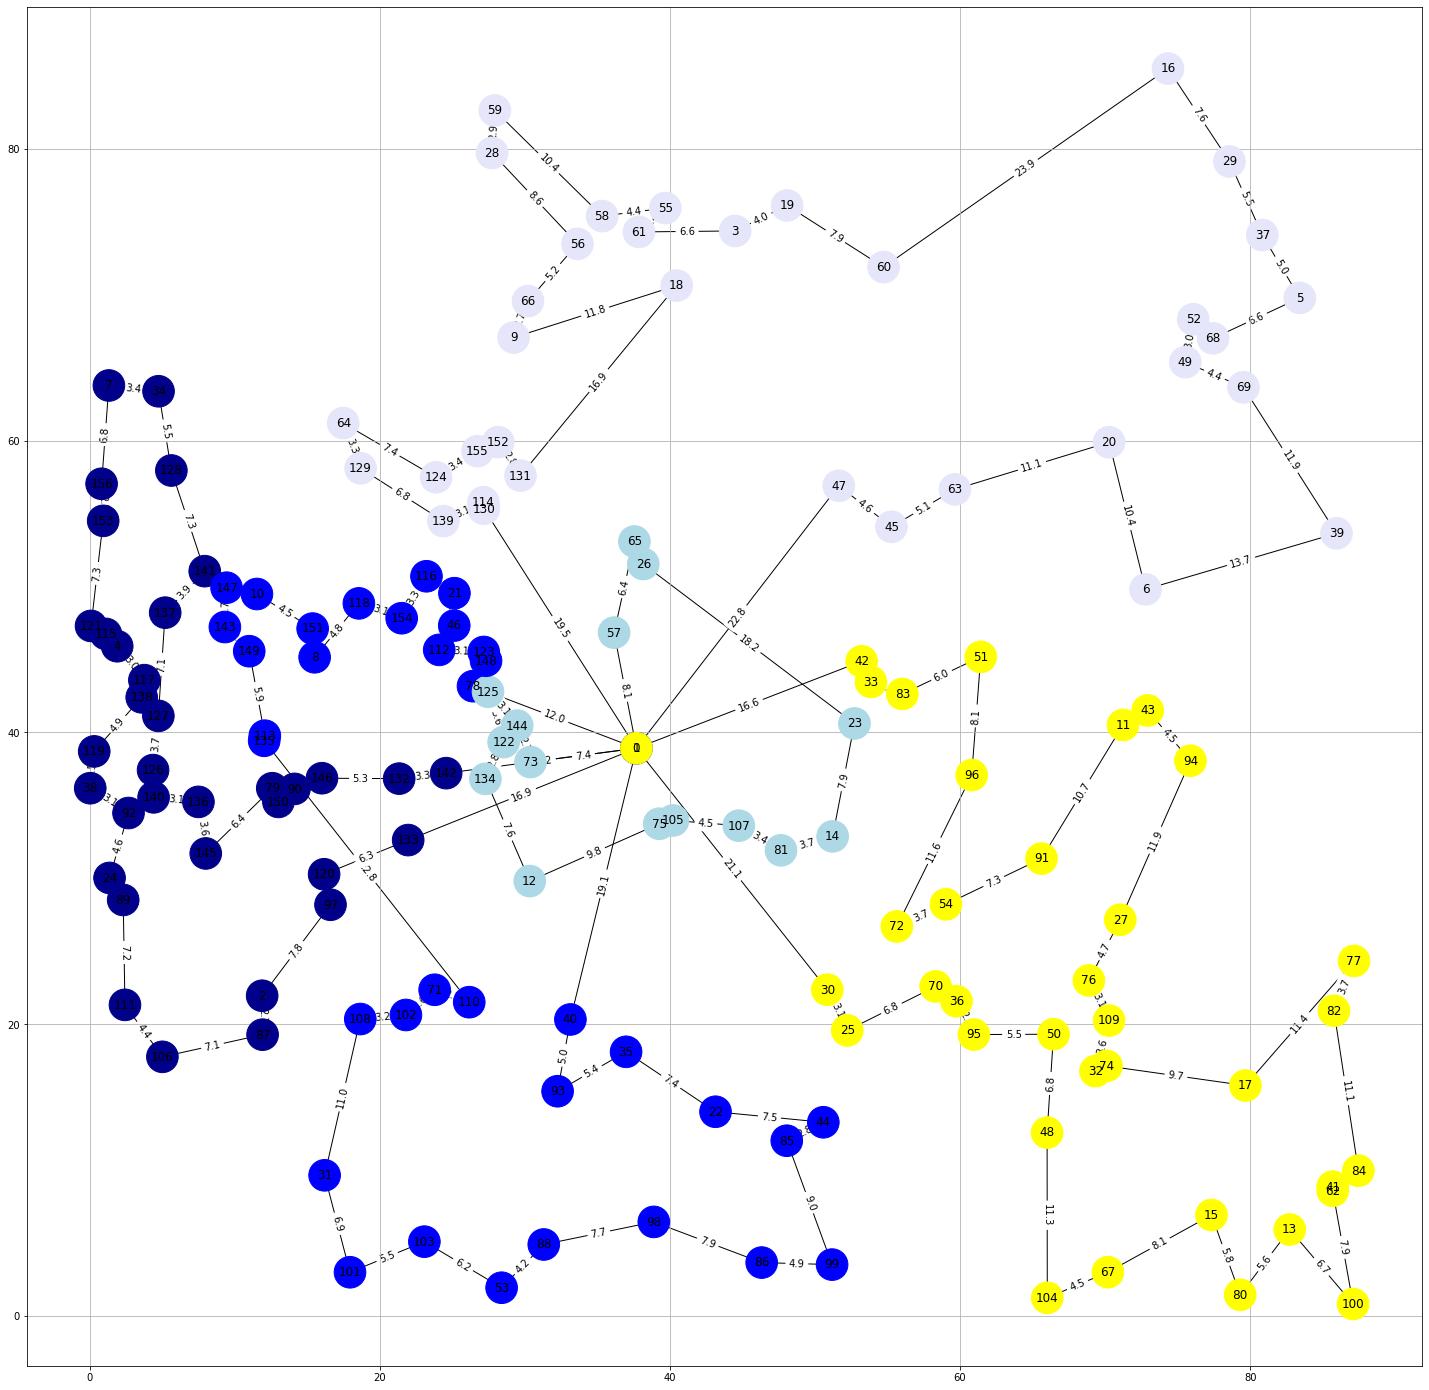

In [22]:
draw_graph_paths(G2, clt_arr, color_map, 25)

### 2 Opt swapping optimization

In [25]:
class Position:

    def __init__(self,x,y):
        self.x = x
        self.y = y      

    def __str__(self):
        return "(" + str(self.x) + ", " + str(self.y) + ") "

    def x_coor(self):
        return self.x

    def y_coor(self):
        return self.y

class Client_node:
    # currently excluded demand

    pos = Position(-1,-1)
    demand = 1

    def __init__(self, id, x, y):
        self.id = id
        self.setPosition(x,y)

    def setPosition(self, x, y):
        self.pos = Position(x, y)

    def get_id(self):
        return self.id

    def __str__(self):
        return str(self.id) + " -> (" + str(self.pos.x) + ", " + \
                str(self.pos.y)  + ") " #-> " + str(self.demand)
        #return "(" + str(self.pos.x) + ", " + \
        #           str(self.pos.y) + " )"

In [31]:
class Route:
    def __init__(self,node_list):
        self.node_list = node_list

    def __getitem__(self, node_index):
        return self.node_list[node_index]

    def __str__(self):
        return_string = "Lenght: " + str(round(self.get_length(), 2))
        return_string += " ( "
        for n in self.node_list:
            return_string += str(n.get_id()) + ", "
        return_string = return_string[:-2]
        return_string += " )"
        return return_string

    def set_node_list(self, node_list):
        self.node_list = node_list

    def get_node_list(self):
        return self.node_list

    def get_length(self):
        prev_node = 0
        first = True
        route_lengt = 0
        for node in self.node_list:
            if not first:
                dist = get_distance_between_client_nodes(prev_node,node)
                route_lengt += dist
            else:
                first = False
            prev_node = node
        return route_lengt
    
    def get_nodes_count(self):
        return len(self.node_list)

    def test_swap_nodes(self, n1_index, n2_index):
        new_node_list = self.node_list.copy()
        new_n1 = new_node_list[n2_index] 
        new_n2 = new_node_list[n1_index]
        new_node_list[n1_index] = new_n1
        new_node_list[n2_index] = new_n2
        new_route = Route(new_node_list)
        return new_route

    def get_2_opt_optimization(self):
        nr_tried_pairs = 0
        prev_route = deepcopy(self)
        changed_nodes = []
        for i in range(1, self.get_nodes_count()-1):
            for j in range(i,self.get_nodes_count()-1):
                nr_tried_pairs += 1
                new_route = self.test_swap_nodes(i,j)
                if new_route.get_length() < prev_route.get_length():
                    prev_route = new_route
                    changed_nodes.append([i,j])
        return prev_route, changed_nodes, nr_tried_pairs

In [32]:
def get_distance_between_client_nodes(n1: Client_node, n2: Client_node):
    # Euclideian
    dist = 0 
    dist = np.sqrt(((n1.pos.x - n2.pos.x) ** 2) + ((n1.pos.y - n2.pos.y) ** 2))
    return dist

In [33]:
def draw_routes_graph(routes, pos_dict, fig_size = 15, do_print=False):
    uniqueList = []
    color_table = ['blue', 'yellow', 'lavender', 'lightblue', 'darkblue', 'magenta', 'orange', 'yellowgreen','indigo']
    customer_count = len(customers)
    total_distance = 0

    color_map = [0]*customer_count
    client_names = np.arange(0, customer_count-1, 1)
    G = nx.Graph() 
    G.add_nodes_from(client_names)

    prev_node = Client_node(n, pos_dict[0][0],  pos_dict[0][1]) # first node is WH
    idx_color = -1
    for route in routes: 
        idx_color += 1
        route_lengt = 0
        for node in route:
            """
            print('prev_node: ', prev_node)
            print('node: ', node)
            print('dist: ', distances[prev_node][node])
            """
            color_map[node.get_id()] = color_table[idx_color]
            dist = get_distance_between_client_nodes(prev_node,node)
            route_lengt += dist
            if prev_node.get_id() != node.get_id():
                #print("add edge i, j:", prev_node, node)
                G.add_edge(prev_node.get_id(), node.get_id(), weight=dist, length=dist)
            prev_node = node
        if do_print:
            print("length: ", route_lengt, route.get_length(),", steps: ", route.get_nodes_count(), ", route: ", route)
        total_distance += route_lengt

    print("total distance: ", total_distance)

    e_labels = {e: round(G.edges[e]['weight'],ndigits=1) for e in G.edges}

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    #plt.title('Client locations')
    nx.draw(G, pos=pos_dict, with_labels = True, node_color=color_map,node_size=1000,ax=ax)
    nx.draw_networkx_edge_labels(G, pos=pos_dict, edge_labels=e_labels)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.grid(True, which='both')
    plt.show()

In [28]:
def print_routes_array(routes_arr):
    orig_total_length = 0
    for r in routes_arr:
        print(r)
        orig_total_length += r.get_length()
    print("original total lenght = ", orig_total_length)

In [29]:
def run_2_opt_optimization(routes, n=1):
    for i in range(n):
        total_length = 0
        optimized_routes = []
        changed_nodes_routes = []
        nr_tried_pairs_routes = []
        j = 0
        for r in routes:
            optimized_route, changed_nodes, nr_tried_pairs = r.get_2_opt_optimization()
            optimized_routes.append(optimized_route)
            changed_nodes_routes.append(changed_nodes)
            nr_tried_pairs_routes.append(nr_tried_pairs)
            total_length += optimized_route.get_length()
            j += 1
        print("new total lenght = ", total_length)
        routes = optimized_routes # recursive-ish
    return routes


In [38]:
# transform to new format with objects
routes_to_optimize = []

for r in unique_routes:
    n_l = []
    for n in r:
        new_node = Client_node(n, pos_dict[n][0],  pos_dict[n][1])
        n_l.append(new_node)
    new_route = Route(n_l)
    routes_to_optimize.append(new_route)

cp_routes = routes_to_optimize.copy()
opt_2_routes = run_2_opt_optimization(cp_routes, n = 5)

new total lenght =  952.8707452933191
new total lenght =  949.7823912504929
new total lenght =  945.79457788157
new total lenght =  945.4054509582699
new total lenght =  945.4054509582699


length:  195.33681410951368 195.33681410951368 , steps:  37 , route:  Lenght: 195.34 ( 0, 40, 93, 35, 22, 85, 44, 99, 86, 98, 88, 53, 103, 101, 31, 108, 102, 110, 71, 135, 113, 149, 143, 147, 10, 151, 8, 118, 154, 116, 21, 46, 112, 123, 148, 78, 0 )
length:  232.63475484547382 232.63475484547382 , steps:  38 , route:  Lenght: 232.63 ( 0, 42, 33, 83, 51, 96, 72, 54, 91, 11, 43, 94, 27, 76, 109, 32, 74, 17, 82, 77, 84, 41, 62, 13, 100, 80, 15, 67, 104, 48, 50, 95, 36, 70, 25, 30, 1, 0 )
length:  259.08242163487165 259.08242163487165 , steps:  37 , route:  Lenght: 259.08 ( 0, 47, 45, 63, 20, 6, 39, 69, 49, 52, 68, 5, 37, 29, 16, 60, 19, 3, 55, 61, 58, 59, 28, 56, 18, 66, 9, 152, 131, 155, 124, 64, 129, 139, 114, 130, 0 )
length:  91.72976389795093 91.72976389795093 , steps:  17 , route:  Lenght: 91.73 ( 0, 73, 144, 125, 122, 134, 12, 75, 105, 107, 81, 14, 23, 26, 65, 57, 0 )
length:  166.6216964704598 166.6216964704598 , steps:  37 , route:  Lenght: 166.62 ( 0, 133, 120, 97, 2, 87, 106, 1

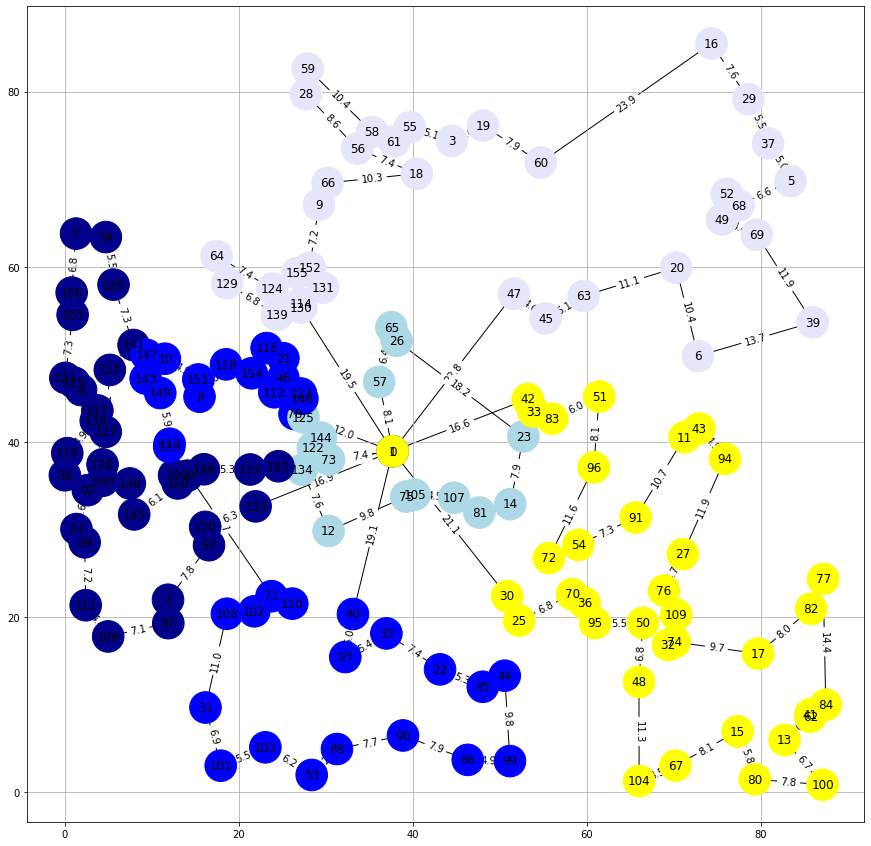

In [39]:
# with Opt_2 optimization within route
draw_routes_graph(opt_2_routes, pos_dict, do_print=True)

# Example from class

In [ ]:
clt_arr = np.array([
[0, 0, 0 , 0],
[1, 14, 40, 3],
[2, 10, 83, 2.7],
[3, 27, 60, 0.9],
[4, 67, 80, 1.2],
[5, 80, 57, 0.8],
[6, 90, 93, 2.6]])

In [ ]:
print(clt_arr)

[[ 0.   0.   0.   0. ]
 [ 1.  14.  40.   3. ]
 [ 2.  10.  83.   2.7]
 [ 3.  27.  60.   0.9]
 [ 4.  67.  80.   1.2]
 [ 5.  80.  57.   0.8]
 [ 6.  90.  93.   2.6]]


In [ ]:
M_val = 6
correction_factor_euclidean_distance = 1.2
wh_location = [0,0]

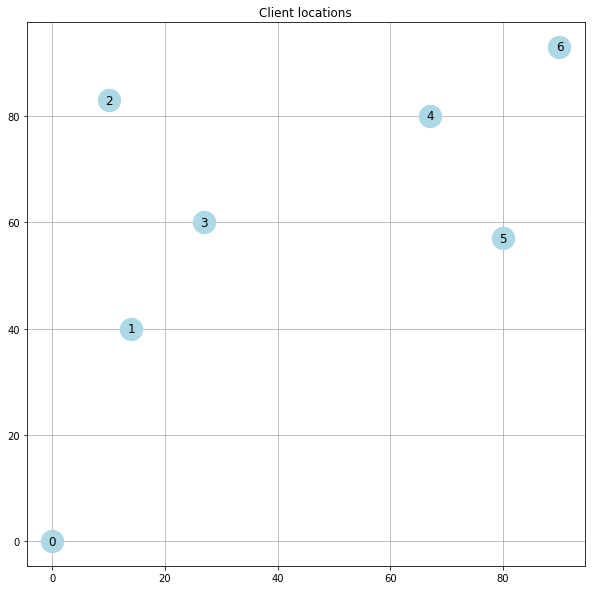

In [ ]:
G, pos_dict = get_graph_data(clt_arr)
plot_clients(G, pos_dict,10)

## Apply CW

In [ ]:
distances, savings = set_CW_data(clt_arr, M_val, correction_factor_euclidean_distance)

customer_count:  7
vehicleCapacity:  6


In [ ]:
print((distances[0]))
print((distances[1]))
print((distances[2]))
print((distances[3]))
print((distances[4]))
print((distances[5]))
print((distances[6]))

[0.0, 50.85508824100102, 100.32028708092895, 78.9541639180607, 125.22044561492343, 117.8751882289059, 155.30151319288552]
[50.85508824100102, 0.0, 51.82277491605404, 28.624465060503752, 79.68036144496334, 81.78508421466593, 111.18633009502561]
[100.32028708092895, 51.82277491605404, 0.0, 34.32083915058022, 68.49467132558561, 89.60714257245345, 96.74709297958259]
[78.9541639180607, 28.624465060503752, 34.32083915058022, 0.0, 53.665631459994955, 63.701805311937584, 85.34354105613382]
[125.22044561492343, 79.68036144496334, 68.49467132558561, 53.665631459994955, 0.0, 31.703627552694975, 31.703627552694975]
[117.8751882289059, 81.78508421466593, 89.60714257245345, 63.701805311937584, 31.703627552694975, 0.0, 44.83570006144657]
[155.30151319288552, 111.18633009502561, 96.74709297958259, 85.34354105613382, 31.703627552694975, 44.83570006144657, 0.0]


In [ ]:
savings

[[[4, 6], 248.818331255114],
 [[5, 6], 228.34100136034488],
 [[4, 5], 211.39200629113435],
 [[2, 6], 158.87470729423188],
 [[2, 4], 157.04606137026678],
 [[3, 4], 150.50897807298918],
 [[3, 6], 148.91213605481244],
 [[2, 3], 144.95361184840945],
 [[3, 5], 133.127546835029],
 [[2, 5], 128.5883327373814],
 [[1, 3], 101.18478709855796],
 [[1, 2], 99.35260040587593],
 [[1, 4], 96.39517241096111],
 [[1, 6], 94.97027133886094],
 [[1, 5], 86.945192255241]]

In [ ]:
CW()

In [ ]:
print_CW_routes_for_customers()

route for customer  0   [0, 1, 2, 0]
route for customer  1   [0, 1, 2, 0]
route for customer  2   [0, 1, 2, 0]
route for customer  3   [0, 3, 4, 6, 5, 0]
route for customer  4   [0, 3, 4, 6, 5, 0]
route for customer  5   [0, 3, 4, 6, 5, 0]
route for customer  6   [0, 3, 4, 6, 5, 0]


In [ ]:
G2, color_map, uniqueList = get_CW_graph(True)

number of routes:  2
length:  202.99815023798402 , steps:  4 , route:  [0, 1, 2, 0]
length:  327.03431122110305 , steps:  6 , route:  [0, 3, 4, 6, 5, 0]
total distance:  530.032461459087


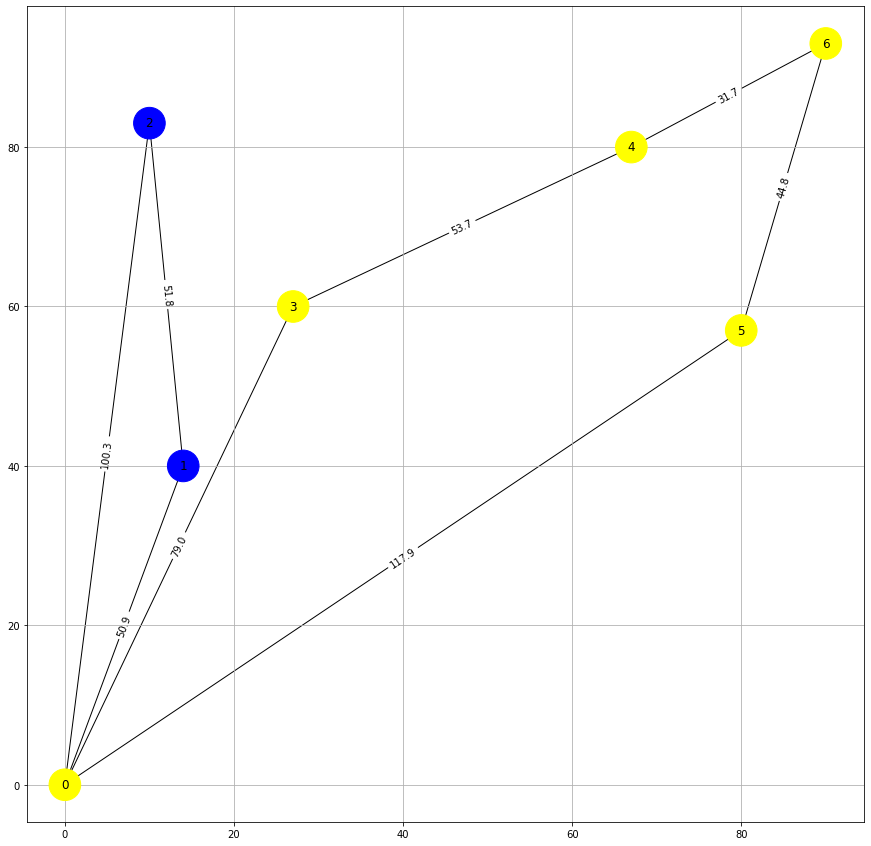

In [ ]:
draw_graph_paths(G2, clt_arr, color_map)